#**1) PRE-PROCESSING**

---



In [47]:
!pip install tldextract

In [75]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns

# Feature extraction Libs
import requests
from urllib.parse import urlparse, urlsplit
import tldextract
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Models and utils
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Keras library for autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model

# Pytorch library for neural network
import torch
from torch import nn, optim
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
DATA_PATH = 'datasets/malicious_urls.csv'
data = pd.read_csv(DATA_PATH)
data.describe()

,url,type
count,663191,663191
unique,653040,5
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [77]:
# Removing duplicates
data = data.drop_duplicates(subset='url')
data.describe()

,url,type
count,653040,653040
unique,653040,5
top,br-icloud.com.br,benign
freq,1,428080


In [78]:
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
663186,http://archive.salisburyjournal.co.uk/2001/3/7/,spam
663187,http://astore.amazon.co.uk/allezvinsfrenchr/de...,spam
663188,http://archive.thisischeshire.co.uk/2000/1/14/...,spam
663189,http://applerugs.co.uk/rugs/product_info.php?p...,spam


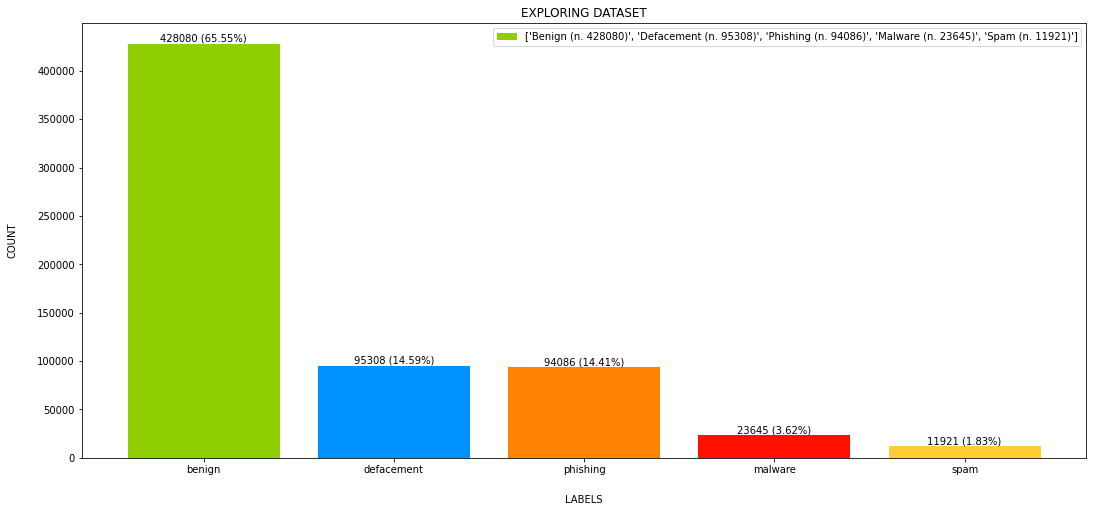

In [79]:
count = data.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

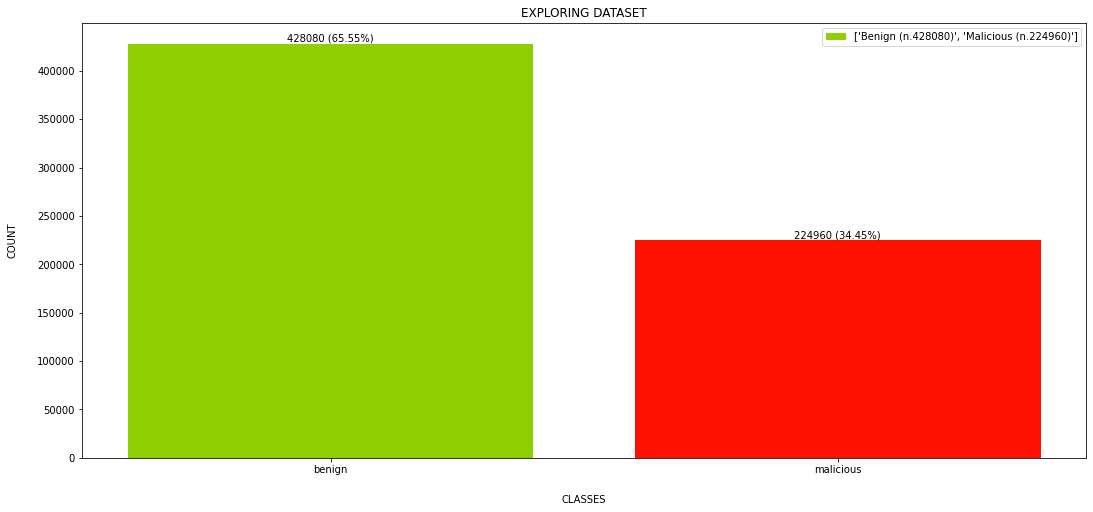

In [80]:
benign = count[0]
malicious = len(data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.legend()
plt.show()

In [54]:
benign_urls = data[data['type'] == 'benign']
defacement_urls = data[data['type'] == 'defacement']
phishing_urls = data[data['type'] == 'phishing']
malware_urls = data[data['type'] == 'malware']
spam_urls = data[data['type'] == 'spam']

benign_urls_sample = random.sample(list(benign_urls.index), 10000)
defacement_urls_sample = random.sample(list(defacement_urls.index), 2500)
phishing_urls_sample = random.sample(list(phishing_urls.index), 2500)
malware_urls_sample = random.sample(list(malware_urls.index), 2500)
spam_urls_sample = random.sample(list(spam_urls.index), 2500)

selected_indexes = benign_urls_sample + defacement_urls_sample + phishing_urls_sample + malware_urls_sample + spam_urls_sample
random.shuffle(selected_indexes)
data_sampled = data.loc[selected_indexes]
data_sampled = data_sampled.reset_index(drop=True)

In [55]:
data_sampled.describe()

,url,type
count,20000,20000
unique,20000,5
top,www.w3.org/TR/css3-roadmap/,benign
freq,1,10000


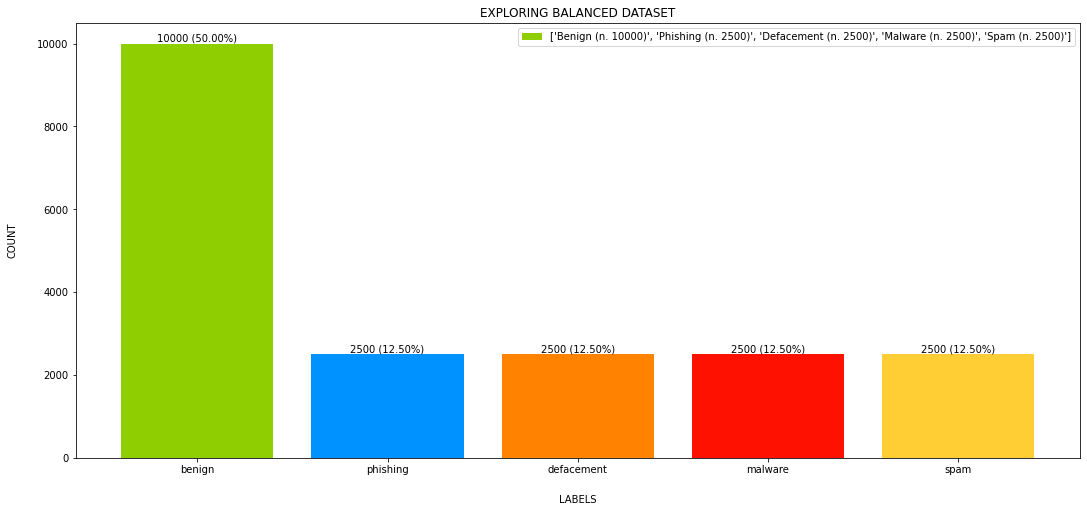

In [56]:
count = data_sampled.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_sampled)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING BALANCED DATASET')
plt.legend()
plt.show()

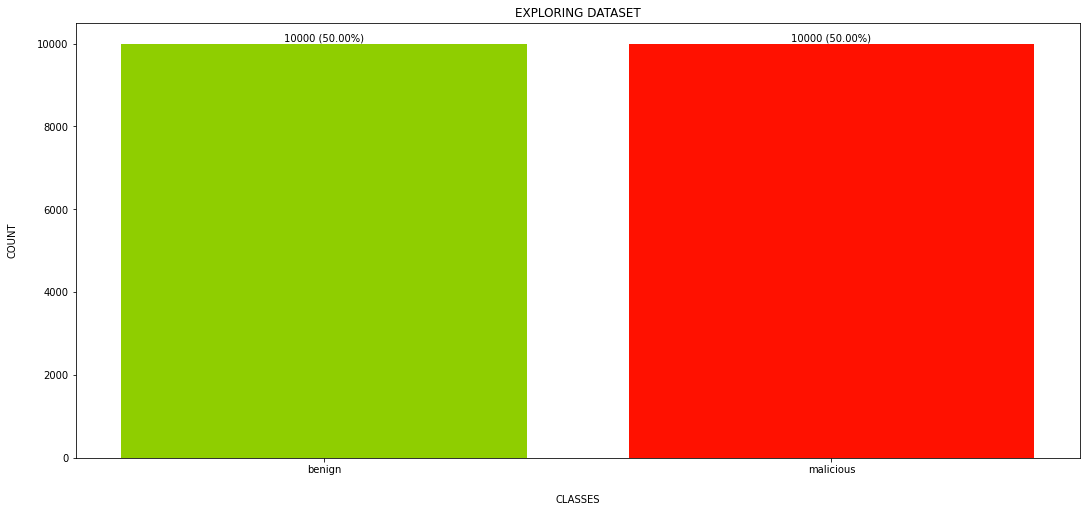

In [57]:
benign = count[0]
malicious = len(data_sampled) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(data_sampled)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

In [58]:
#file_path = '/content/urls_sampled.csv'
#data_sampled.to_csv(file_path, index=False)
data = pd.read_csv('datasets/urls_sampled.csv')
data.describe()

,url,type
count,20000,20000
unique,20000,5
top,http://173.15.162.156:4755/Mozi.m,benign
freq,1,10000


#**2) FEATURES ENGINEERING**

---



In [59]:
#
# Number of character '.' in URL
# Return: numeric
#
def count_dots(url: str):
    return url.count('.')


#
# Number of subdomain levels
# Return: numeric
#
def count_subdomains(url: str):
    subdomain = tldextract.extract(url).subdomain
    return len(subdomain.split('.')) if len(subdomain) != 0 else 0


#
# The depth of URL
# Return: numeric
#
def get_path_level(url: str):
    path = urlsplit(url).path
    path = path[1:] if len(path) > 0 and path[0] == '/' else path
    path = path[:-1] if len(path) > 0 and path[-1] == '/' else path
    return len(path.split('/')) if len(path) > 0 else 0


#
# The length of URL
# Return: numeric
#
def get_len(url: str):
    return len(url)


#
# Number of the dash character '-' in URL
# Return: numeric
#
def count_dash(url: str):
    return url.count('-')


#
# There exists a character '@' in URL
# Return: boolean
#
def check_at_symbol(url: str):
    return '@' in url


#
# There exists a character '~' in URL
# Return: boolean
#
def check_tilde_symbol(url: str):
    return '~' in url


#
# Number of the underscore character '_' in URL
# Return: numeric
#
def count_underscore(url: str):
    return url.count('_')


#
# Number of the percent character '%' in URL
# Return: numeric
#
def count_percent(url: str):
    return url.count('%')


#
# Number of the query components
# Return: numeric
#
def count_query_components(url: str):
    query_components = urlparse(url).query.split("&") if len(urlparse(url).query) > 0 else ''
    return len(query_components)


#
# Number of the ampersand character '&' in URL
# Return: numeric
#
def count_ampersand(url: str):
    return url.count('&')


#
# Number of the hash character '#' in URL
# Return: numeric
#
def count_hash(url: str):
    return url.count('#')


#
# Number of the numeric character
# Return: numeric
#
def count_digits(url: str):
    return sum(c.isdigit() for c in url)


#
# Check if there exists a HTTPS in website URL
# Return: boolean
#
def check_Https(url: str):
    try:
        req = requests.get(url, timeout=1).url
        return req.startswith('https')
    except Exception as e:
        return False


#
# Check if the IP address is used in the hostname of the website URL
# Return: boolean
#
def check_IP_address(url: str):
    return not bool(sum(not c.isdigit() and c != '.' for c in tldextract.extract(url).domain))


#
# Check if TLD is used as a part of the subdomain in website URL
# Return: boolean
#
def check_tld_in_subdomain(url: str):
    res = tldextract.extract(url)
    return res.domain in res.subdomain


#
# Check if TLD is used in the link of website URL
# Return: boolean
#
def check_tld_in_path(url: str):
    return tldextract.extract(url).domain in urlsplit(url).path


#
# Check if HTTPS is disordered in the hostname of website URL
# Return: boolean
#
def check_https_in_hostname(url: str):
    return 'https' in urlsplit(url).netloc


#
# Length of hostname
# Return: numeric
#
def get_hostname_length(url: str):
    return len(urlsplit(url).netloc)


#
# Length of the link path
# Return: numeric
#
def get_path_length(url: str):
    return len(urlparse(url).path)


#
# Length of the query string
# Return: numeric
#
def get_query_length(url):
    return len(urlparse(url).query)


#
# There exists a slash '//' in the link path
# Return: boolean
#
def check_double_slash_in_path(url: str):
    return '//' in urlparse(url).path


#
# Compute the lexical features by URL
# Return: Pandas.Series
#
def get_lexical_features(url, label):
    if not url.startswith(('http://', 'https://', 'ftp://')):
        url = 'http://' + url
    return [
        url,
        count_dots(url),
        count_subdomains(url),
        get_path_level(url),
        get_len(url),
        count_dash(url),
        check_at_symbol(url),
        check_tilde_symbol(url),
        count_underscore(url),
        count_percent(url),
        count_query_components(url),
        count_ampersand(url),
        count_hash(url),
        count_digits(url),
        check_Https(url),
        check_IP_address(url),
        check_tld_in_subdomain(url),
        check_tld_in_path(url),
        check_https_in_hostname(url),
        get_hostname_length(url),
        get_path_length(url),
        get_query_length(url),
        check_double_slash_in_path(url),
        label
    ]

In [60]:
data_features = pd.DataFrame({
    'url':[],
    'numDots':[],
    'subdomainLevel':[],
    'pathLevel':[],
    'urlLength':[],
    'numDash':[], 
    'atSymbol':[],
    'tildeSymbol':[],
    'numUnderscore':[],
    'numPercent':[],
    'numQueryComponents':[],
    'numApersand':[],          
    'numHash':[],
    'numDigits':[],
    'https':[],
    'ipAddress':[], 
    'domainInSubdomains':[],
    'domainInPaths':[],
    'httpsInHostname':[],
    'hostnameLength':[],
    'pathLength':[],
    'queryLength':[],
    'doubleSlash':[],
    'type': []
})

In [61]:
# for i in range(len(data)):
#     url = data.loc[i, 'url']
#     label = data.loc[i, 'type']
#     if (i % 1000 == 0):
#         print('Rows processed: ',i)
#     try:
#         data_features.loc[i] = get_lexical_features(url, label)
#     except Exception as e:
#         print('\n')
#         print(e)
#         print('url: ',url)
#         print('index: ',i)
#         continue
# data_features.to_csv('/content/urls_with_features.csv', index = False)

#**3) EXPLORATIVE DATA ANALYSIS**

---



In [62]:
DATA_PATH = 'datasets/urls_with_features.csv'
data = pd.read_csv(DATA_PATH)
data.describe()

,numDots,subdomainLevel,pathLevel,urlLength,numDash,numUnderscore,numPercent,numQueryComponents,numApersand,numHash,numDigits,hostnameLength,pathLength,queryLength
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.482300,0.491650,2.169350,70.553750,1.289450,0.48425,0.365150,0.668000,0.45590,0.000650,7.918400,17.517150,27.930800,17.603400
std,1.498532,0.908775,1.548383,71.897412,2.689336,1.51399,3.837832,1.563745,1.32153,0.029148,15.195482,10.205705,26.701628,67.855277
min,0.000000,0.000000,0.000000,13.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,38.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,12.000000,10.000000,0.000000
50%,2.000000,0.000000,2.000000,53.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,4.000000,16.000000,21.000000,0.000000
75%,3.000000,1.000000,3.000000,83.000000,1.000000,0.00000,0.000000,0.000000,0.00000,0.000000,10.000000,20.000000,37.000000,0.000000
max,25.000000,18.000000,18.000000,1424.000000,39.000000,20.00000,147.000000,28.000000,27.00000,2.000000,332.000000,244.000000,755.000000,1388.000000


In [63]:
# Null values check
data.isnull().any()

url                   False
numDots               False
subdomainLevel        False
pathLevel             False
urlLength             False
numDash               False
atSymbol              False
tildeSymbol           False
numUnderscore         False
numPercent            False
numQueryComponents    False
numApersand           False
numHash               False
numDigits             False
https                 False
ipAddress             False
domainInSubdomains    False
domainInPaths         False
httpsInHostname       False
hostnameLength        False
pathLength            False
queryLength           False
doubleSlash           False
type                  False
dtype: bool

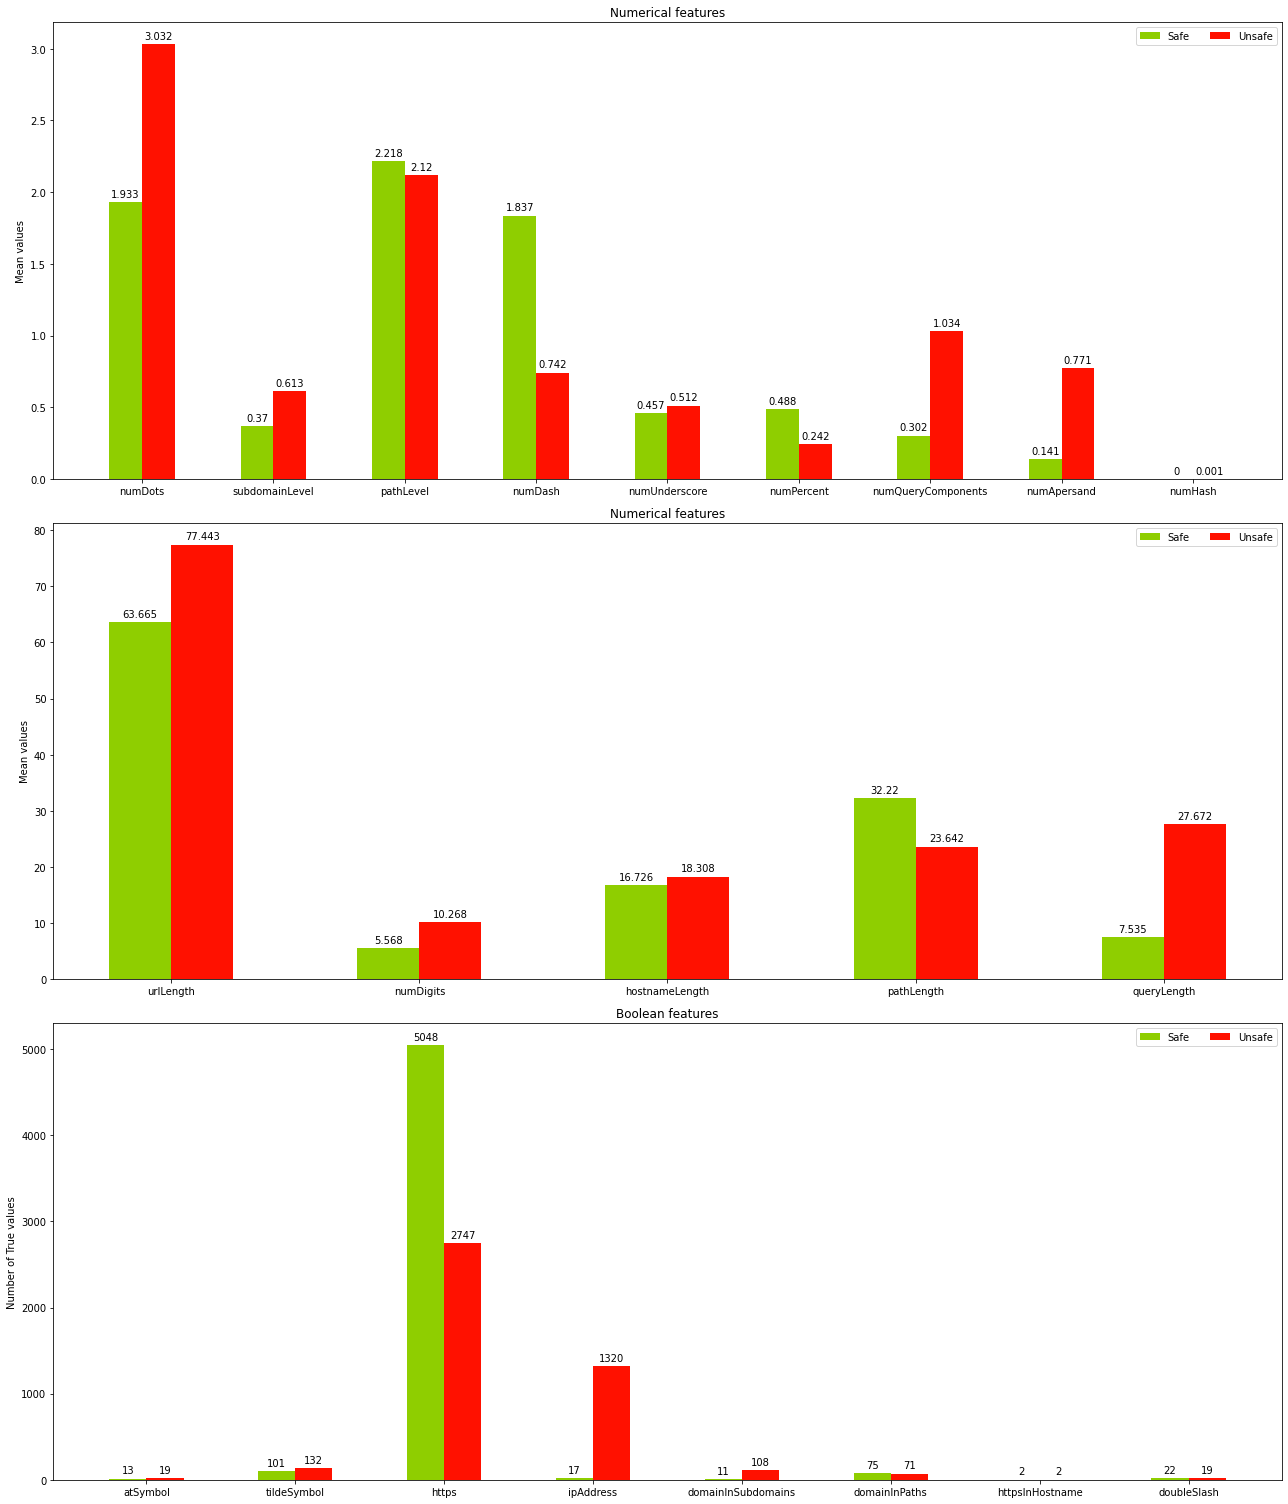

In [64]:
safe = data[data['type'] == 'benign']
unsafe = data[data['type'] != 'benign']

# Numerical features
labels_x1 = ['numDots', 'subdomainLevel', 'pathLevel', 'numDash', 'numUnderscore', 'numPercent', 'numQueryComponents', 'numApersand', 'numHash']
labels_x2 = ['urlLength', 'numDigits', 'hostnameLength', 'pathLength', 'queryLength']
# Boolean features
labels_x3 = ['atSymbol', 'tildeSymbol', 'https', 'ipAddress', 'domainInSubdomains', 'domainInPaths', 'httpsInHostname', 'doubleSlash']

features_to_plot1 = {'Safe': [], 'Unsafe': []}
features_to_plot2 = {'Safe': [], 'Unsafe': []}
features_to_plot3 = {'Safe': [], 'Unsafe': []}

for i in labels_x1:
    features_to_plot1['Safe'].append(safe.loc[:, i].mean())
    features_to_plot1['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x2:
    features_to_plot2['Safe'].append(safe.loc[:, i].mean())
    features_to_plot2['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x3:
    features_to_plot3['Safe'].append(safe.loc[:, i].sum())
    features_to_plot3['Unsafe'].append(unsafe.loc[:, i].sum())

x1 = np.arange(len(labels_x1))  # the label locations
x2 = np.arange(len(labels_x2))  # the label locations
x3 = np.arange(len(labels_x3))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(18, 21))

for attribute, measurement in features_to_plot1.items():
    offset = width * multiplier
    rects = ax1.bar(x1 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax1.bar_label(rects, padding = 3)
    multiplier += 1
ax1.set_ylabel('Mean values')
ax1.set_title('Numerical features')
ax1.set_xticks(x1 + (width/2), labels_x1)
ax1.legend(loc = 'upper right', ncol = 2)

for attribute, measurement in features_to_plot2.items():
    offset = width * multiplier
    rects = ax2.bar(x2 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax2.bar_label(rects, padding = 3)
    multiplier += 1
ax2.set_ylabel('Mean values')
ax2.set_title('Numerical features')
ax2.set_xticks(x2 + (width*2.5), labels_x2)
ax2.legend(loc = 'upper right', ncol = 2)

for attribute, measurement in features_to_plot3.items():
    offset = width * multiplier
    rects = ax3.bar(x3 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax3.bar_label(rects, padding = 3)
    multiplier += 1
ax3.set_ylabel('Number of True values')
ax3.set_title('Boolean features')
ax3.set_xticks(x3 + (width*4.5), labels_x3)
ax3.legend(loc = 'upper right', ncol = 2)

plt.tight_layout()
plt.show()

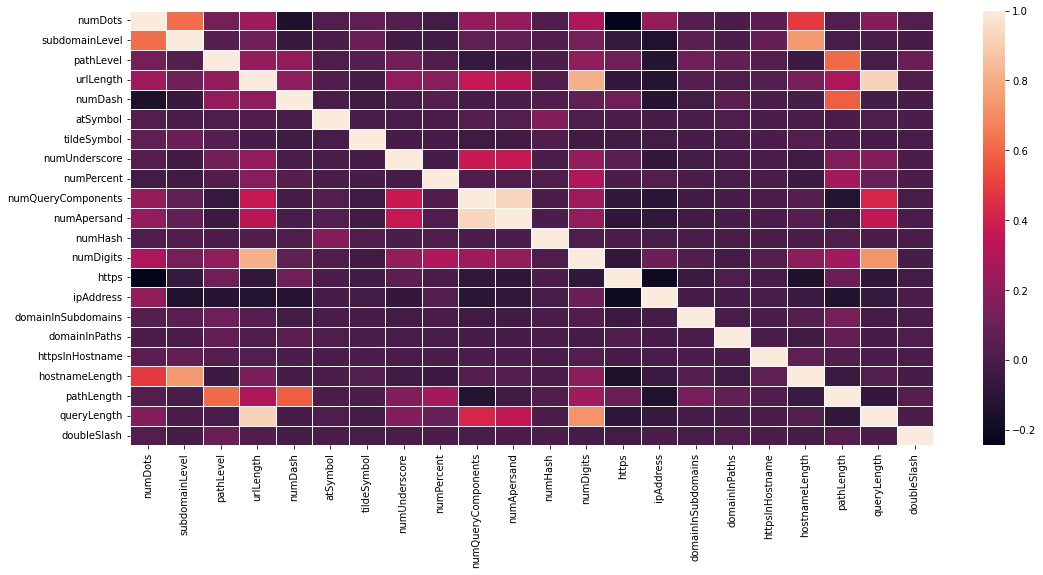

In [65]:
plt.figure()
sns.heatmap(data.corr(), linewidths=.5)
plt.show()

### Function to split dataset ###

In [66]:
def get_data_split(X, y, isScaled=False, isTensor=False, fSelection=[]):

    if len(fSelection) > 0:
        X = X[fSelection]
    
    if isScaled:
        scaler = MinMaxScaler()
        X_scal = X
        for c in X_scal:
            if c != 'ipAddress' or c != 'https':
                X_scal[[c]] = scaler.fit_transform(X_scal[[c]])
        X = X_scal

    X_train, X_test, y_train, y_test = train_test_split(
                                            X.values.astype('float64'),
                                            y.values.astype('float64'),
                                            train_size = .8,
                                            test_size = .2,
                                            random_state = 2,
                                            shuffle = True,
                                            stratify = y)

    if isTensor:
        X_train = torch.tensor(data = X_train, dtype=torch.float32)
        X_test = torch.tensor(data = X_test, dtype=torch.float32)
        y_train = torch.tensor(data = y_train.squeeze(), dtype=torch.float32)
        y_test = torch.tensor(data = y_test.squeeze(), dtype=torch.float32)
        if torch.cuda.is_available():
            X_train = X_train.cuda()
            X_test = X_test.cuda()
            y_train = y_train.cuda()
            y_test = y_test.cuda()

    return X_train, X_test, y_train, y_test

#**4) FEATURES SELECTION**

---



In [67]:
selected_features = ['numDots', 'subdomainLevel', 'pathLevel', 'urlLength', 'numDash',
       'numUnderscore', 'numPercent', 'numQueryComponents', 'numApersand', 'numDigits', 'https',
       'ipAddress', 'hostnameLength', 'pathLength', 'queryLength']

X = data[selected_features]
X.https = X.https.replace({True: 1, False: 0})
X.ipAddress = X.ipAddress.replace({True: 1, False: 0})

y = data[['type']]
y.loc[y['type'] != 'benign', 'type'] = 1
y.loc[y['type'] == 'benign', 'type'] = 0

#**4.1) PRINCIPAL COMPONENT ANALYSIS (PCA)**

---

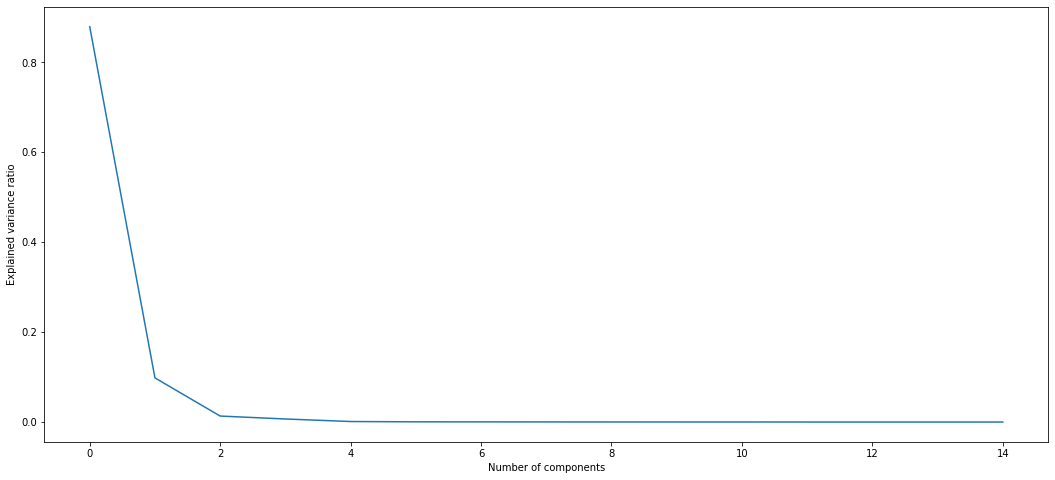

In [68]:
# Create a PCA object and fit the data
pca = PCA()
pca.fit(X)

# Plot the explained variance ratio for each component
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

In [69]:
def get_pca_features(components: int):
    pca = PCA(n_components = components)
    return pca.fit_transform(X.values)

#**4.2) AUTOENCODER**

---

In [73]:
n_inputs = X.values.shape[1]
n_inputs

15

In [83]:
X_train, X_test, y_train, y_test = get_data_split(X, y)

# Scaling data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
# Define autoencoder
visible = Input(shape = (n_inputs,))

#Define Encoder
#level 1
e = Dense(n_inputs*2)(visible) # e = encoder
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# level 2 
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

#Bottleneck 
n_bottleneck = round(float(n_inputs)/2.0)
bottleneck = Dense(n_bottleneck)(e)

# Define Decoder
#level 1
d = Dense(n_inputs)(bottleneck) # d = dencoder
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#level 2
d = Dense(n_inputs*2)(d) # d = dencoder
d = BatchNormalization()(d)
d = LeakyReLU()(d)

#Output layer
output = Dense(n_inputs, activation = 'linear')(d)

#Define autoencoder model
model = Model(inputs = visible, outputs = output)

#compile autoencoder
model.compile(optimizer = 'adam', loss = 'mse')

In [88]:
# Fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs = 20, batch_size = 16, verbose = 2, validation_data = (X_test,X_test))

Epoch 1/20
1000/1000 - 5s - loss: 4.9949e-04 - val_loss: 2.6794e-04 - 5s/epoch - 5ms/step
Epoch 2/20
1000/1000 - 5s - loss: 5.0727e-04 - val_loss: 3.4464e-04 - 5s/epoch - 5ms/step
Epoch 3/20
1000/1000 - 5s - loss: 4.9538e-04 - val_loss: 3.7115e-04 - 5s/epoch - 5ms/step
Epoch 4/20
1000/1000 - 4s - loss: 4.8197e-04 - val_loss: 4.4398e-04 - 4s/epoch - 4ms/step
Epoch 5/20
1000/1000 - 6s - loss: 4.8542e-04 - val_loss: 3.3853e-04 - 6s/epoch - 6ms/step
Epoch 6/20
1000/1000 - 6s - loss: 5.3749e-04 - val_loss: 3.3512e-04 - 6s/epoch - 6ms/step
Epoch 7/20
1000/1000 - 5s - loss: 4.8396e-04 - val_loss: 3.4165e-04 - 5s/epoch - 5ms/step
Epoch 8/20
1000/1000 - 6s - loss: 4.7024e-04 - val_loss: 2.9646e-04 - 6s/epoch - 6ms/step
Epoch 9/20
1000/1000 - 5s - loss: 5.3663e-04 - val_loss: 3.3231e-04 - 5s/epoch - 5ms/step
Epoch 10/20
1000/1000 - 6s - loss: 5.6125e-04 - val_loss: 3.0934e-04 - 6s/epoch - 6ms/step
Epoch 11/20
1000/1000 - 6s - loss: 4.8783e-04 - val_loss: 2.6978e-04 - 6s/epoch - 6ms/step
Epoch 12

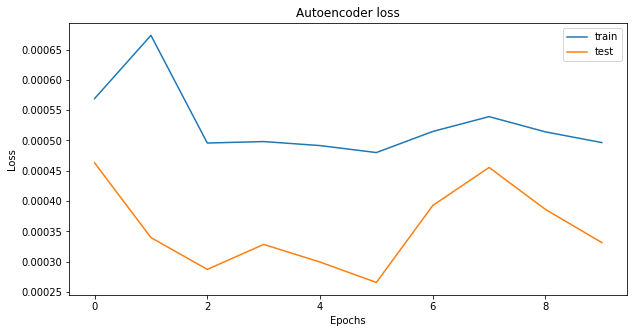

In [87]:
#Plot Loss
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.title('Autoencoder loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Autoencoderloss.png')

In [90]:
#Define an encoder model without the decoder
encoder = Model(inputs =visible, outputs = bottleneck)

# encode the  data
X_train_encode = encoder.predict(X_train)
X_test_encode = encoder.predict(X_test)

In [91]:
X_train_encode.shape

(16000, 8)

#**5) MODELS DEFINITION**

---



## **Modello 1 | Support Vector Machine**

In [ ]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
acc = accuracy_score(pred, y_test)

In [ ]:
print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

## **Modello 2 | AdaBoost**

In [ ]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
pred = adaboost.predict(X_test)
acc = accuracy_score(pred, y_test)

In [ ]:
print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

In [ ]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [ ]:
fSelection_adaboost = ['pathLength', 'hostnameLength', 'numDigits', 'urlLength', 'numDots']
X_train_short, X_test_short, _, _ = get_data_split(X, y, fSelection=fSelection_adaboost)

adaboost = AdaBoostClassifier()
adaboost.fit(X_train_short, y_train)
pred = adaboost.predict(X_test_short)
acc = accuracy_score(pred, y_test)

print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

## **Modello 3 | Random Forest**

In [ ]:
X_train, X_test, y_train, y_test = get_data_split(X, y)
rf = RandomForestClassifier(random_state=3)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
acc = accuracy_score(pred, y_test)

In [ ]:
print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m \n')
print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

# cf_matrix = confusion_matrix(y_test, pred)
# plot = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt= '0.2%')
# plt.show()

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [ ]:
fSelection = ['numDots', 'pathLength', 'urlLength', 'hostnameLength']
X_train_short, X_test_short, _, _ = get_data_split(X, y, fSelection=fSelection)

rf = RandomForestClassifier(random_state=3)
rf.fit(X_train_short, y_train)
pred_short = rf.predict(X_test_short)
acc_short = accuracy_score(pred_short, y_test)

print(f'Test Accuracy :\033[32m \033[01m {acc_short*100:.2f}% \033[30m \033[0m \n')
print(classification_report(y_test, pred_short, target_names=['safe_URL', 'unsafe_URL']))

## **Modello 4 | Neural Network**

In [ ]:
class SimpleNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=15, out_features=100)
        self.layer_2 = nn.Linear(in_features=100, out_features=1)
        self.layer_3 = nn.Tanh()

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

class WideNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(15, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.tanh = nn.Tanh()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.tanh(self.output(x))
        return x

In [ ]:
def train_NN(net, X_train_net, X_test_net, y_train_net, y_test_net, n_epochs, verbose=True):

    torch.manual_seed(42)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1)

    # Build training and evaluation loop
    for epoch in range(n_epochs):
        ### Training
        net.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = net(X_train_net).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 

        loss = loss_fn(y_logits, y_train_net) # Using nn.BCEWithLogitsLoss works with raw logits
        acc = accuracy_fn(y_true=y_train_net, y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        net.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = net(X_test_net).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits, y_test_net)
            test_acc = accuracy_fn(y_true=y_test_net, y_pred=test_pred)

        # Print out what's happening every 10 epochs
        if epoch % 100 == 0 and verbose == True:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
X_train_net, X_test_net, y_train_net, y_test_net = get_data_split(X, y, isTensor=True)
X_train_scal, X_test_scal, _, _ = get_data_split(X, y, isScaled=True, isTensor=True)

net1 = SimpleNetwork().to(device)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"SIMPLE NETWORK ON ORIGINAL DATA":<25}\n')
print(''.join(['> ' for i in range(40)]))
train_NN(net1, X_train_net, X_test_net, y_train_net, y_test_net, n_epochs=1000, verbose=True)

net2 = SimpleNetwork().to(device)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"SIMPLE NETWORK ON SCALED DATA":<25}\n')
print(''.join(['> ' for i in range(40)]))
train_NN(net2, X_train_net, X_test_net, y_train_net, y_test_net, n_epochs=1000, verbose=True)

In [ ]:
net3 = WideNetwork().to(device)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"WIDE NETWORK ON ORIGINAL DATA":<25}\n')
print(''.join(['> ' for i in range(40)]))
train_NN(net3, X_train_net, X_test_net, y_train_net, y_test_net, n_epochs=1000, verbose=True)

net4 = WideNetwork().to(device)
print(''.join(['> ' for i in range(40)]))
print(f'\n{"WIDE NETWORK ON SCALED DATA":<25}\n')
print(''.join(['> ' for i in range(40)]))
train_NN(net4, X_train_net, X_test_net, y_train_net, y_test_net, n_epochs=1000, verbose=True)

#**6) EXPERIMENTAL PLAYGROUND**

---



## **SVM | PCA Features**

In [ ]:
features_PCA = {}

for i in range(2,10,2):
    X_pca_i = get_pca_features(i)
    
    # Split dataset
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(
        X_pca_i.astype('float64'), 
        y.values.astype('float64'),
        train_size = .8,
        test_size = .2,
        random_state = 2,
        shuffle = True,
        stratify = y)
    
    key_i = str(i)
    features_PCA[key_i] = {}
    features_PCA[key_i]['X_train'] = X_train_pca
    features_PCA[key_i]['X_test'] = X_test_pca
    features_PCA[key_i]['y_train'] = y_train
    features_PCA[key_i]['y_test'] = y_test

In [ ]:
# Training and evaluate SVM on different number of components
for k in features_PCA.keys():
    X_train = features_PCA[k]['X_train']
    X_test = features_PCA[k]['X_test']
    y_train = features_PCA[k]['y_train']
    y_test = features_PCA[k]['y_test']
    
     
    # Model training
    svc_i = SVC(kernel='rbf')
    svc_i.fit(X_train, y_train)
    pred_i = svc_i.predict(X_test)
    acc_i = accuracy_score(pred_i, y_test)
    
    print("Number of components: \033[34m %s \033[0m"%k)
    print(f'Test Accuracy :\033[32m \033[01m {acc_i*100:.2f}% \033[30m \033[0m \n')
    print(classification_report(y_test, pred_i, target_names=['safe_URL', 'unsafe_URL']))

## **SVM | Autoencoder Features**

## **SVM | Different kernels**

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    X_train, X_test, y_train, y_test = get_data_split(X, y)
    svc = SVC(kernel=k)
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    acc = accuracy_score(pred, y_test)
    
    print("Kernel: \033[34m%s \033[0m"%k)
    print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m \n')
    print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

## **ADABoost | PCA Features**

In [ ]:
# Training and evaluate ADABoost on different number of components
for k in features_PCA.keys():
    X_train = features_PCA[k]['X_train']
    X_test = features_PCA[k]['X_test']
    y_train = features_PCA[k]['y_train']
    y_test = features_PCA[k]['y_test']
    
    adaboost = AdaBoostClassifier()
    adaboost.fit(X_train, y_train)
    pred = adaboost.predict(X_test)
    acc = accuracy_score(pred, y_test)
    
    print("Number of components: \033[34m %s \033[0m"%k)
    print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m \n')
    print(classification_report(y_test, pred, target_names=['safe_URL', 'unsafe_URL']))

## **ADABoost | Autoencoder Features**

## **Random Forest | Hyperpar. Tuning**

In [ ]:
acc_gini = []
acc_entropy = []
acc_log = []
max_iter = 100

for i in range(max_iter):
    rf_gini = RandomForestClassifier(criterion='gini', random_state=i)
    rf_gini.fit(X_train, y_train)
    pred = rf_gini.predict(X_test)
    acc_gini.append(accuracy_score(pred, y_test))

    rf_entropy = RandomForestClassifier(criterion='entropy', random_state=i)
    rf_entropy.fit(X_train, y_train)
    pred = rf_entropy.predict(X_test)
    acc_entropy.append(accuracy_score(pred, y_test))
    
    '''
    rf_log = RandomForestClassifier(criterion='log_loss', random_state=i)
    rf_log.fit(X_train, y_train)
    pred = rf_log.predict(X_test)
    acc_log.append(accuracy_score(pred, y_test))'''

print(''.join(['> ' for i in range(40)]))
print(f'\n{"":<25}{"GINI":<18}{"ENTROPY":<18}{"LOG_LOSS":<18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'\n{"MEAN_ACCURACY":<25}{np.mean(acc_gini):<18.4}{np.mean(acc_entropy):<18.4}{np.mean(acc_log):<18.4}\n')

In [ ]:
plt.plot([i for i in range(len(acc_gini[:50]))], acc_gini[:50], label="acc_gini")
plt.plot(acc_entropy[:50], label="acc_entropy")
plt.plot(acc_log[:50], label="acc_log")

plt.xticks(rotation = 60, ha="right")
plt.xlabel('RANDOM STATE', labelpad=20)
plt.ylabel('ACCURACY', labelpad=20)
plt.legend()

In [ ]:
# Number of trees in random forest
n_estimators = [i * 100 for i in range(1, 11)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(''.join(['> ' for i in range(40)]))
print(f'\n{"HYPERPARAMETER":<25}{"RANGE_VALUES":<18}\n')
print(''.join(['> ' for i in range(40)]))
for k, v in random_grid.items():
    print(f'\n{k:<25}{str(v):<18}')

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=3)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
                estimator = rf,
                param_distributions = random_grid,
                n_iter = 100, cv = 5, verbose = 2, random_state = 3, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

In [ ]:
base_model = RandomForestClassifier(random_state=3)
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)
base_accuracy = accuracy_score(base_pred, y_test)

best_model = rf_random.best_estimator_
best_model.fit(X_train, y_train)
best_pred = best_model.predict(X_test)
best_accuracy = accuracy_score(best_pred, y_test)

gain = ((best_accuracy - base_accuracy) * 100 / base_accuracy)

print(''.join(['> ' for i in range(40)]))
print(f'\n{"":<25}{"BASE_MODEL":<18}{"BEST_MODEL":<18}{"IMPROVEMENT":<18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'\n{"ACCURACY":<25}{base_accuracy:<18.4}{best_accuracy:<18.4}{gain:<18.2f}\n')

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=3)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
param_grid = {
               'n_estimators': [100, 200, 300],
               'max_features': ['log2'],
               'criterion': ['entropy'],
               'max_depth': [10, 19],
               'min_samples_split': [2, 5],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]
              }
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
# Fit the random search model
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

In [ ]:
best_model_g = grid_search.best_estimator_
best_model_g.fit(X_train, y_train)
best_pred_g = best_model_g.predict(X_test)
best_accuracy_g = accuracy_score(best_pred_g, y_test)

gain = ((best_accuracy_g - base_accuracy) * 100 / base_accuracy)

print(''.join(['> ' for i in range(40)]))
print(f'\n{"":<25}{"BASE_MODEL":<18}{"BEST_MODEL":<18}{"IMPROVEMENT":<18}\n')
print(''.join(['> ' for i in range(40)]))
print(f'\n{"ACCURACY":<25}{base_accuracy:<18.4}{best_accuracy_g:<18.4}{gain:<18.2f}\n')

In [ ]:
from sklearn.model_selection import cross_val_score

best_param = {
    'n_estimators': 200,
    'criterion': 'entropy',
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'max_features': 'log2',
    'bootstrap': False,
    'random_state': 3
}

rf_cv = RandomForestClassifier(best_param)
rf_cv.fit(X_train, y_train)
pred_cv = rf_cv.predict(X_test)

scores = cross_val_score(rf_cv, X, y, cv=5)